In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,LabelEncoder
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
import graphviz

In [89]:
fraud_data = pd.read_csv('Fraud_data.csv')
ip_address = pd.read_csv('IpAddress_to_Country.csv')

In [90]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [91]:
ip_address.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [92]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [93]:
ip_address.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
lower_bound_ip_address    138846 non-null float64
upper_bound_ip_address    138846 non-null int64
country                   138846 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


## Question 1: For each user, determine her country based on the numeric IP address.

In [94]:
country = []
for _, row in fraud_data.iterrows():
    temp= ip_address[(ip_address['lower_bound_ip_address'] <= row['ip_address']) & (ip_address['upper_bound_ip_address'] >= row['ip_address'])]
    if len(temp) ==1:
        country.append(temp['country'].values[0])
    else:
        country.append('NA')

In [95]:
fraud_data['country'] = country

In [96]:
fraud_data.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [97]:
#Another way to do it:
#merge the Ip information table to the fraud table
#ip_lb = ip_address.lower_bound_ip_address.values
#ip_ub = ip_address.upper_bound_ip_address.values
#ip= fraud_data.ip_address.values

#i, j = np.where((ip[:,None] >= ip_lb) & (ip[:,None] <= ip_ub))

In [98]:
#temp= pd.DataFrame(np.column_stack([fraud_data.ip_address[i], ip_address.country.values[j]]), columns = [['ip_address', 'Country']])
#fraud_data.merge(temp, how = 'left', left_on = ['ip_address'], right_on = ['ip_address'])

## Question 2: Build a model to predict whether an activity is fraudulent or not. Explain how different assumptions about the cost of false positives vs false negatives would impact the model.

In [99]:
# Feature engineering

# find the difference between signup time and purchase time
fraud_data['time_diff']= (pd.to_datetime(fraud_data['purchase_time'])- pd.to_datetime(fraud_data['signup_time'])).apply(lambda x: x.days)



In [100]:
# find the number of unique device used for each user id
tmp1= fraud_data.groupby('user_id')['device_id'].count().reset_index()
tmp1.columns = ['user_id', 'device_count']
fraud_data=fraud_data.merge(tmp1, how = 'left', on = 'user_id', right_index = False)


In [101]:
# find the number of ip address used for each user id
tmp2 = fraud_data.groupby('user_id')['ip_address'].count().reset_index()
tmp2.columns= ['user_id', 'ip_address_count']
fraud_data= fraud_data.merge(tmp2, how= 'left', on= 'user_id', right_index = False)


In [76]:
# find the number of unique browser used for each user id
tmp3= fraud_data.groupby('user_id')['browser'].count().reset_index()
tmp3.columns = ['user_id', 'browser_count']
fraud_data = fraud_data.merge(tmp3, how = 'left', on= 'user_id', right_index = False)

In [104]:
# some other data cleaning:
fraud_data['signup_dayofweek'] = pd.to_datetime(fraud_data['signup_time']).apply(lambda x: x.dayofweek)
fraud_data['signup_week']= pd.to_datetime(fraud_data['signup_time']).apply(lambda x: x.week)


In [119]:
#fraud_data['sex'] = fraud_data['sex'].astype('category')
#fraud_data['source']= fraud_data['source'].astype('category')
fraud_data['country']= fraud_data['country'].astype('category')
fraud_data['class'] = fraud_data['class'].astype('category')
df= pd.get_dummies(fraud_data, columns= ['sex', 'source'])

In [135]:
encoder= LabelEncoder()
fraud_data['source']= encoder.fit_transform(fraud_data['source'])
fraud_data['sex'] = encoder.fit_transform(fraud_data['sex'])
fraud_data['browser'] = encoder.fit_transform(fraud_data['browser'])
fraud_data['country'] = encoder.fit_transform(fraud_data['country'])

In [137]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151112 entries, 0 to 151111
Data columns (total 17 columns):
user_id             151112 non-null int64
signup_time         151112 non-null object
purchase_time       151112 non-null object
purchase_value      151112 non-null int64
device_id           151112 non-null object
source              151112 non-null int64
browser             151112 non-null int64
sex                 151112 non-null int64
age                 151112 non-null int64
ip_address          151112 non-null float64
class               151112 non-null category
country             151112 non-null int64
time_diff           151112 non-null int64
device_count        151112 non-null int64
ip_address_count    151112 non-null int64
signup_dayofweek    151112 non-null int64
signup_week         151112 non-null int64
dtypes: category(1), float64(1), int64(12), object(3)
memory usage: 19.7+ MB


In [138]:
X= fraud_data[['time_diff', 'device_count', 'ip_address_count', 'signup_dayofweek', 'signup_week', 'age', 'sex', 'country', 'source']]

In [139]:
y = fraud_data['class']

In [140]:
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.25)

In [141]:
clf= DecisionTreeClassifier()
clf.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [151]:
pred = clf.predict(x_test)

In [154]:
print(classification_report(y_test,pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95     34184
           1       0.49      0.57      0.53      3594

   micro avg       0.90      0.90      0.90     37778
   macro avg       0.72      0.76      0.74     37778
weighted avg       0.91      0.90      0.91     37778



In [162]:
pred_proba = clf.predict_proba(x_test)
fpr,tpr,thresholds = roc_curve(y_test,1-pd.DataFrame(pred_proba).iloc[:,0])

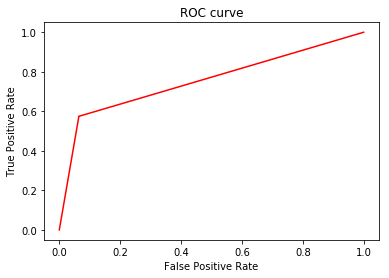

In [164]:
plt.plot(fpr,tpr, color = 'red')
plt.xlim([-.05, 1.05])
plt.ylim([-.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

In [165]:
## Very poorly fitted. Let's try random forest

In [167]:
RF_model = RandomForestClassifier(n_estimators= 50)
RF_model.fit(x_train, y_train)
RF_pred= RF_model.predict(x_test)

In [168]:
print(classification_report(y_test, RF_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98     34184
           1       0.98      0.54      0.70      3594

   micro avg       0.96      0.96      0.96     37778
   macro avg       0.97      0.77      0.84     37778
weighted avg       0.96      0.96      0.95     37778



In [171]:
RF_proba = RF_model.predict_proba(x_test)
fpr1,tpr1,thresholds = roc_curve(y_test,1-pd.DataFrame(pred_proba).iloc[:,0])

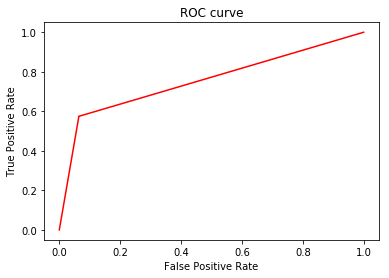

In [172]:
plt.plot(fpr1,tpr1, color = 'red')
plt.xlim([-.05, 1.05])
plt.ylim([-.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()